<a href="https://colab.research.google.com/github/quinbez/Image_Classification_Using_Vision_Transformer/blob/main/Image_Classification_Using_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.12


In [2]:
import torch
torch.__version__

'2.1.0+cu121'

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

# specify the dataset url
dataset_url = "https://www.kaggle.com/datasets/sauravagarwal/flower-classification"
# download the dataset
od.download(dataset_url , ".")

Skipping, found downloaded files in "./flower-classification" (use force=True to force download)


In [7]:
train_dir = "flower-classification/flowers/flowers/flower_photos/train"
test_dir = "flower-classification/flowers/flowers/flower_photos/test"

## **Creating Datasets and Dataloaders**

In [8]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders( train_dir: str, test_dir: str, batch_size: int, transform: transforms.Compose, num_workers: int = NUM_WORKERS):
  train_data = datasets.ImageFolder(train_dir, transform = transform)
  test_data = datasets.ImageFolder(test_dir, transform = transform)

  # Get class names
  class_names = train_data.classes

  train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers= num_workers, pin_memory = True)
  test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)

  return train_dataloader, test_dataloader, class_names

In [9]:
IMG_SIZE = 224

manual_transforms= transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [10]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b786082dd20>,
 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

torch.Size([3, 224, 224]) tensor(3)


(-0.5, 223.5, 223.5, -0.5)

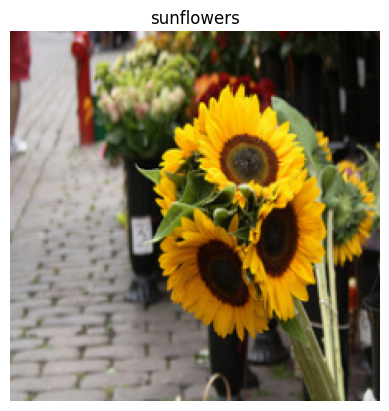

In [11]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[6], label_batch[6]
print(image.shape, label)

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

**Tasks**

1. Turn image into patches
2. Flatten the patch feature maps into a single dimension
3. Convert the output into Desried output (flattened 2D patches)

In [12]:
# Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size:int = 16, embedding_dim: int = 768):
    super().__init__()

    # Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels = in_channels, out_channels = embedding_dim, kernel_size = patch_size, stride = patch_size, padding = 0)
    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input size must be divisible by patch size, image_shape: {image_resolution}, patch_size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

In [13]:
patch_size = 16

def set_seeds(seed: int = 42):
  # Set the seed for general torch operations
  torch.manual_seed(seed)
  # Set the seed for CUDA torch operations (ones that happen on the GPU)
  torch.cuda.manual_seed(seed)

set_seeds()

patchify = PatchEmbedding(in_channels = 3, patch_size = 16, embedding_dim = 768)
print("Input image shape: ", image.unsqueeze(0).shape)
patch_embedded_image = patchify(image.unsqueeze(0))
print("Output patch embedding shape: ", patch_embedded_image.shape)

Input image shape:  torch.Size([1, 3, 224, 224])
Output patch embedding shape:  torch.Size([1, 196, 768])


In [14]:
print(patch_embedded_image)
print("Shape of patch embedding: ", patch_embedded_image.shape, " -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6576,  0.2321,  0.0518,  ...,  0.2678, -0.2148,  0.1260],
         [-0.8013,  0.1934, -0.2381,  ...,  0.6233, -0.3567,  0.3202],
         [-0.5886, -0.1551,  0.0375,  ...,  0.3200, -0.3237,  0.2682],
         ...,
         [-0.2697,  0.1213, -0.0065,  ...,  0.2419, -0.2199,  0.0819],
         [-0.2857,  0.0756, -0.1464,  ...,  0.2288, -0.2132,  0.4034],
         [ 0.0699,  0.1262, -0.3689,  ...,  0.3058, -0.1185,  0.0651]]],
       grad_fn=<PermuteBackward0>)
Shape of patch embedding:  torch.Size([1, 196, 768])  -> [batch_size, number_of_patches, embedding_dimension]


In [15]:
set_seeds()
patch_size = 16

# Print shape of original image tensor and get the image dimensions
print("Image tensor shape: ", image.shape)
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print("Input image with batch dimension shape: ", x.shape)

patch_embedding_layer= PatchEmbedding(in_channels = 3, patch_size = patch_size, embedding_dim = 768)
patch_embedding = patch_embedding_layer(x)
print("Shape of patch embedding: ", patch_embedding.shape)

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)
print("Shape of class token embedding", class_token.shape)

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print("Patch embedding concatenated with the class token: ", patch_embedding_class_token.shape)

number_of_patches = int((height * width) // patch_size**2)

position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad = True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print("Adding up patch embedding and position embedding", patch_and_position_embedding.shape)

print(patch_embedding_class_token)

Image tensor shape:  torch.Size([3, 224, 224])
Input image with batch dimension shape:  torch.Size([1, 3, 224, 224])
Shape of patch embedding:  torch.Size([1, 196, 768])
Shape of class token embedding torch.Size([1, 1, 768])
Patch embedding concatenated with the class token:  torch.Size([1, 197, 768])
Adding up patch embedding and position embedding torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6576,  0.2321,  0.0518,  ...,  0.2678, -0.2148,  0.1260],
         [-0.8013,  0.1934, -0.2381,  ...,  0.6233, -0.3567,  0.3202],
         ...,
         [-0.2697,  0.1213, -0.0065,  ...,  0.2419, -0.2199,  0.0819],
         [-0.2857,  0.0756, -0.1464,  ...,  0.2288, -0.2132,  0.4034],
         [ 0.0699,  0.1262, -0.3689,  ...,  0.3058, -0.1185,  0.0651]]],
       grad_fn=<CatBackward0>)


## **Creating layers used in Transformer's encoder**

**torch.nn.LayerNorm().**
Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension.

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

**torch.nn.MultiheadAttention()**
Multi-Head Self Attention (MSA)

* embed_dim - the embedding dimension D .

* num_heads - how many attention heads to use (this is where the term "multihead" comes from)

* dropout - whether or not to apply dropout to the attention layer

* batch_first - does our batch dimension come first? (yes it does)


In [16]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim:int = 768, num_heads:int = 12, attn_dropout: float = 0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim, num_heads = num_heads, dropout = attn_dropout, batch_first = True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x, key = x, value = x, need_weights = False)

    return attn_output

## **MLP Block**

In [17]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim: int = 768, mlp_size:int =  3076, dropout: float = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    # Creating the Multilayer perceptron (MLP) layer
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dim),
        nn.Dropout( p = dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

## **Creating a Transformer Encoder by combining our custom made layers**

In [18]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1,     # Amount of dropout for dense layers from Table 3 for ViT-Base
               attn_dropout: float = 0 ):    # Amount of dropout for attention layers
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim, num_heads = num_heads, attn_dropout = attn_dropout)
    self.MLPBlock = MLPBlock(embedding_dim = embedding_dim, mlp_size = mlp_size, dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x     # Create residual connection for MSA block (add the input to the output)
    x = self.MLPBlock(x) + x      # Create residual connection for MLP block (add the input to the output)

    return x


**Transformer Encoder block created!**

In [19]:
!pip install torchinfo

In [20]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

# Print an input and output summary of our Transformer Encoder
summary(model = transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names =["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (MLPBlock)                              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## **Building a Vision Transformer**

In [21]:
class  ViT(nn.Module):
  def __init__(self, img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,
               num_classes:int=1000):
     super().__init__()
     assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

     # Calculate number of patches (height * width/patch^2)
     self.num_patches = (img_size * img_size) // patch_size**2
     self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
     self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
     self.embedding_dropout = nn.Dropout(p=embedding_dropout)
     self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

     self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
         embedding_dim = embedding_dim,
         num_heads = num_heads,
         mlp_size = mlp_size,
         mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])

     self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])

    return x


## **Train Model**

In [22]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

vit = ViT(num_classes = len(class_names))

def train_steps(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float,float]:

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):

      X,y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)

    return test_loss, test_acc

In [27]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  model.to(device)
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_steps(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                        device = device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f}"
    )
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [28]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = train(model= vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6376 | train_acc: 0.2331 | test_loss: 1.5842 | test_acc: 0.2778
Epoch: 2 | train_loss: 1.6157 | train_acc: 0.2291 | test_loss: 1.6303 | test_acc: 0.1562
Epoch: 3 | train_loss: 1.6050 | train_acc: 0.2311 | test_loss: 1.5975 | test_acc: 0.2778
Epoch: 4 | train_loss: 1.6020 | train_acc: 0.2414 | test_loss: 1.6072 | test_acc: 0.1562
Epoch: 5 | train_loss: 1.6033 | train_acc: 0.2463 | test_loss: 1.6063 | test_acc: 0.1562
Epoch: 6 | train_loss: 1.6035 | train_acc: 0.2463 | test_loss: 1.6075 | test_acc: 0.1562
Epoch: 7 | train_loss: 1.6032 | train_acc: 0.2462 | test_loss: 1.6092 | test_acc: 0.1562
Epoch: 8 | train_loss: nan | train_acc: 0.2103 | test_loss: nan | test_acc: 0.1562
Epoch: 9 | train_loss: nan | train_acc: 0.1714 | test_loss: nan | test_acc: 0.1562
Epoch: 10 | train_loss: nan | train_acc: 0.1714 | test_loss: nan | test_acc: 0.1562


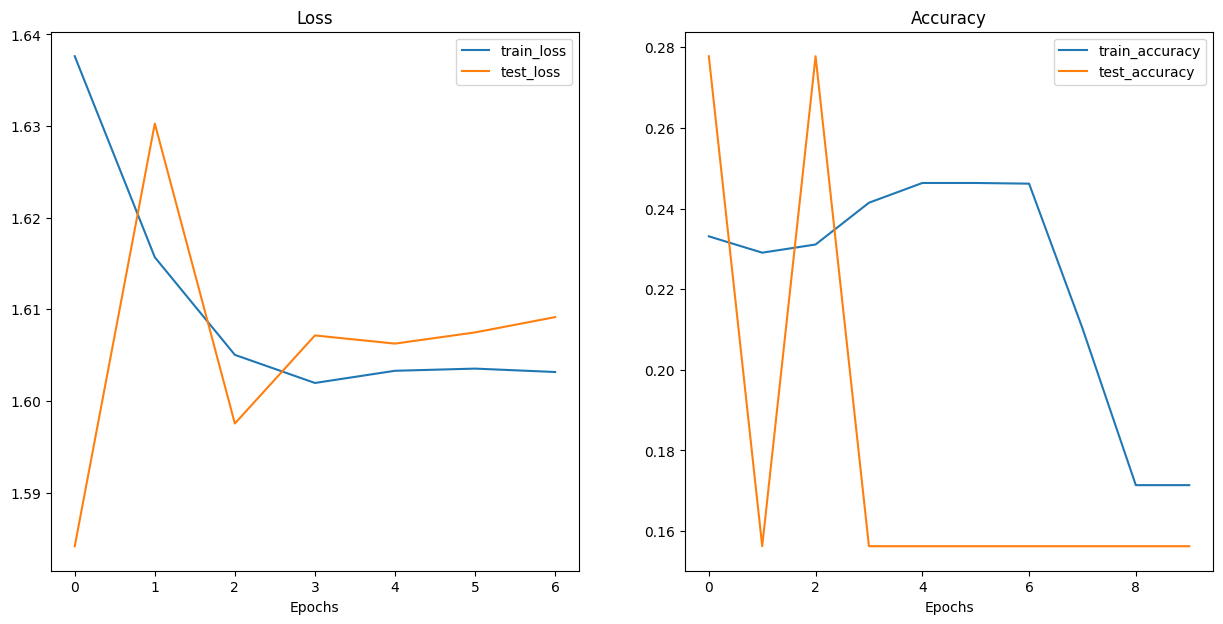

In [30]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize = (15,7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_accuracy, label = "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(results)

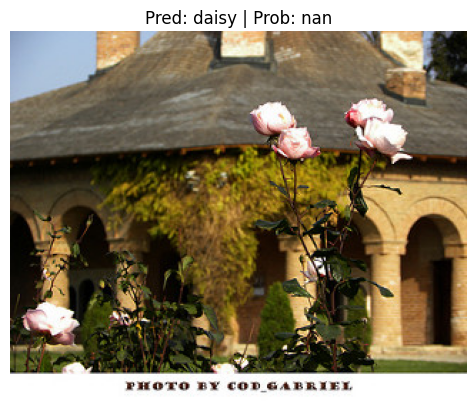

In [37]:
from PIL import Image

def pred_and_plot_image(
   model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",):

  img = Image.open(image_path)

  if transform:
    image_transform = transform
  else:
    image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

  model.to(device)

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim = 0)

    # Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  plt.figure()
  plt.imshow(img)
  plt.title(
      f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
  )
  plt.axis(False)

custom_image_path = "/content/flower-classification/flowers/flowers/flower_photos/test/roses/5181899042_0a6ffe0c8a_n.jpg"
pred_and_plot_image(model = vit,
                image_path = custom_image_path,
                class_names = class_names)


